In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt
import pandas as pd
import numpy as np
import random
import networkx as nx
import seaborn as sns

from scipy.stats import randint as sp_randint
from sklearn import preprocessing, svm
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from time import time
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

# prepare data

In [2]:
# train - test data
x_train_final = pd.read_csv("features/X_train_10.csv")
x_test_final = pd.read_csv("features/X_test_10.csv")
print("train： %s, test： %s" % (len(x_train_final),len(x_test_final)))

y_train_final = x_train_final['link']
y_test_final = x_test_final['link']

train_graph = nx.from_pandas_edgelist(x_train_final, "node1", "node2", create_using=nx.DiGraph())
x_train_final.drop(['node1', 'node2','link'],axis=1,inplace=True)
x_test_final.drop(['node1', 'node2','link'],axis=1,inplace=True)

train： 28638, test： 12276


In [3]:
# standardization
scaler = preprocessing.StandardScaler().fit(x_train_final)
x_train_final_std = pd.DataFrame(scaler.fit_transform(x_train_final.values), columns=x_train_final.columns)
x_test_final_std = pd.DataFrame(scaler.fit_transform(x_test_final.values), columns=x_test_final.columns)

# feature selection (by RandomForest)

In [4]:
feat_labels = x_train_final.columns
clf_test = RandomForestClassifier(n_estimators=200,random_state=25)
clf_test.fit(x_train_final,y_train_final)
importance = clf_test.feature_importances_
indices = np.argsort(importance)[::-1] #得到list中score從大到小的值，每個值在list中的index

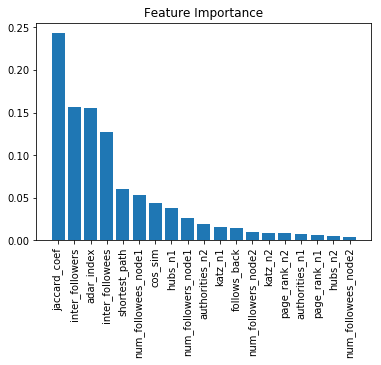

In [5]:
plt.title('Feature Importance')
plt.bar(range(x_train_final.shape[1]), importance[indices], align='center')
plt.xticks(range(x_train_final.shape[1]), feat_labels[indices], rotation = 90)
plt.show()

In [6]:
sfm = SelectFromModel(clf_test, threshold=0.05, prefit=True) #prefit=True when the model has already been fitted before
x_selected = sfm.transform(x_train_final)
for i in range(x_selected.shape[1]):
    print("%2d)  %-*s %f" % (i+1, 20, feat_labels[indices[i]], importance[indices[i]]))

 1)  jaccard_coef         0.243406
 2)  inter_followers      0.155961
 3)  adar_index           0.155322
 4)  inter_followees      0.127657
 5)  shortest_path        0.059599
 6)  num_followees_node1  0.053436


# discriminative abilities of features

In [7]:
train_pos = x_train_final_std[y_train_final==1]
train_neg = x_train_final_std[y_train_final==0]
col_list = x_train_final_std.columns

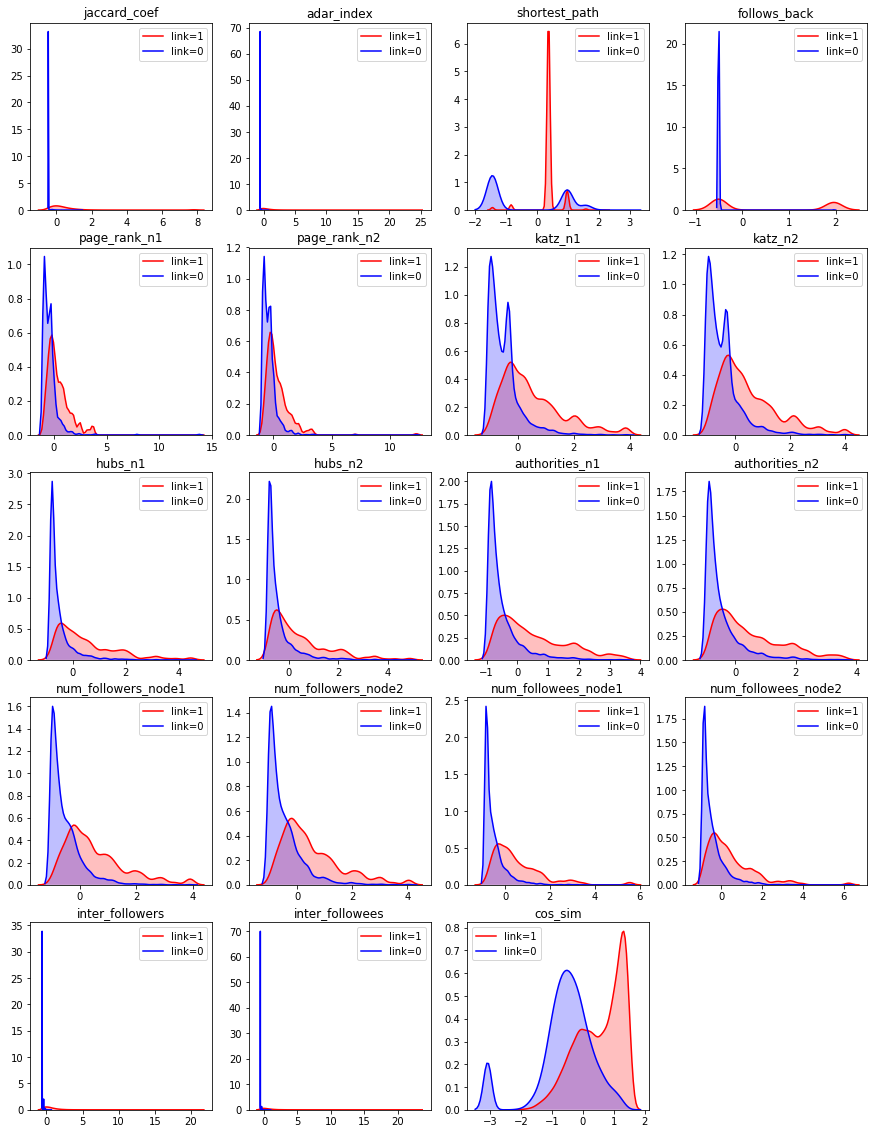

In [8]:
plt.figure(figsize=(15,20))
for i in range(0,len(col_list)):
    plt.subplot(5,4,1+i)
    plt.title(col_list[i])
    sns.kdeplot(train_pos[col_list[i]], shade=True, color='red', label='link=1')
    sns.kdeplot(train_neg[col_list[i]], shade=True, color='blue', label='link=0')

# feature extracion (by PCA)

In [9]:
pca = PCA(n_components=2)

In [10]:
x_train_pca = pca.fit_transform(x_train_final_std)
x_test_pca = pca.transform(x_test_final_std)

### 2D PCA

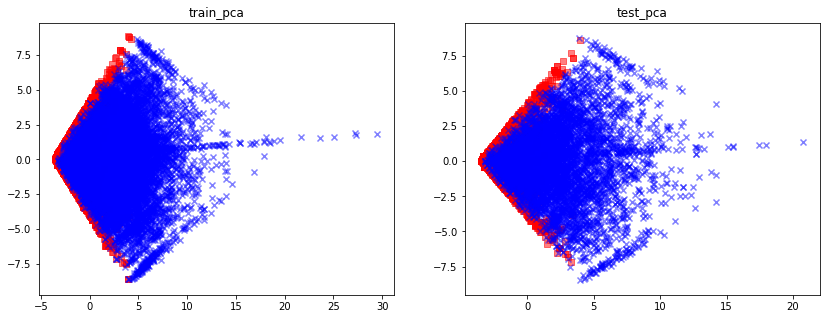

In [11]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title('train_pca')
plt.scatter(x_train_pca[y_train_final==0, 0], x_train_pca[y_train_final==0, 1],
           color='red', marker='s', alpha=0.5)
plt.scatter(x_train_pca[y_train_final==1, 0], x_train_pca[y_train_final==1, 1],
           color='blue', marker='x', alpha=0.5)

plt.subplot(122)
plt.title('test_pca')
x_test_pca = pca.fit_transform(x_test_final_std)
plt.scatter(x_test_pca[y_test_final==0, 0], x_test_pca[y_test_final==0, 1],
           color='red', marker='s', alpha=0.5)
plt.scatter(x_test_pca[y_test_final==1, 0], x_test_pca[y_test_final==1, 1],
           color='blue', marker='x', alpha=0.5)
plt.show()

# 從train、test看起來其是可以區分的，只是為非線性

### 3D PCA

In [12]:
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_final_std)

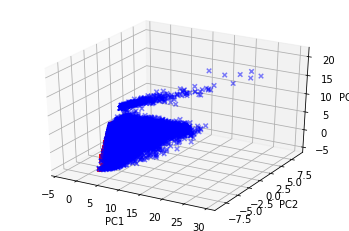

In [13]:
#plt.figure(figsize=(10,7))
x, y, z = x_train_pca[:, 0], x_train_pca[:, 1], x_train_pca[:, 2]
ax = plt.subplot(111, projection='3d')  
ax.scatter(x[y_train_final==0], y[y_train_final==0], z[y_train_final==0], c='r', marker='s', alpha=0.5) 
ax.scatter(x[y_train_final==1], y[y_train_final==1], z[y_train_final==1], c='b', marker='x', alpha=0.5)

ax.set_zlabel('PC3') 
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
plt.show()

### select features

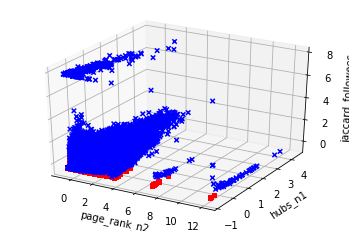

In [14]:
x, y, z = x_train_final_std['page_rank_n2'], x_train_final_std['hubs_n1'], x_train_final_std['jaccard_coef']
ax = plt.subplot(111, projection='3d')  
ax.scatter(x[y_train_final==0], y[y_train_final==0], z[y_train_final==0], c='r', marker='s', alpha=1) 
ax.scatter(x[y_train_final==1], y[y_train_final==1], z[y_train_final==1], c='b', marker='x', alpha=1)

ax.set_zlabel('jaccard_followees') 
ax.set_ylabel('hubs_n1')
ax.set_xlabel('page_rank_n2')
plt.show()

# model (kernel SVM)

In [15]:
def plot_decision_regions(X, y, classifier, resolution=0.1):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))+1])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

In [16]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_final_std)

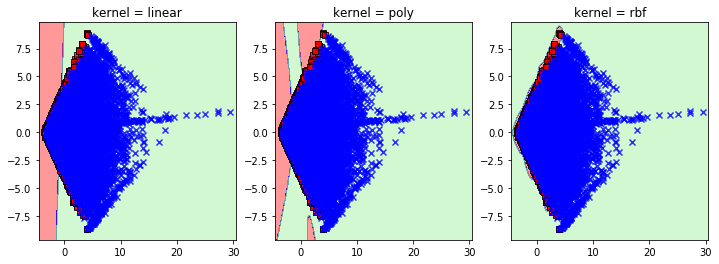

In [17]:
fignum = 1
plt.figure(figsize=(12,4))

for kernel in ('linear', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=2)
    clf.fit(x_train_pca, y_train_final)
    #plt.figure(fignum, figsize=(4, 3))
    plt.subplot(1,3,fignum)
    plot_decision_regions(x_train_pca, y_train_final, classifier=clf)
    plt.title('kernel = ' + str(kernel))
    fignum = fignum + 1

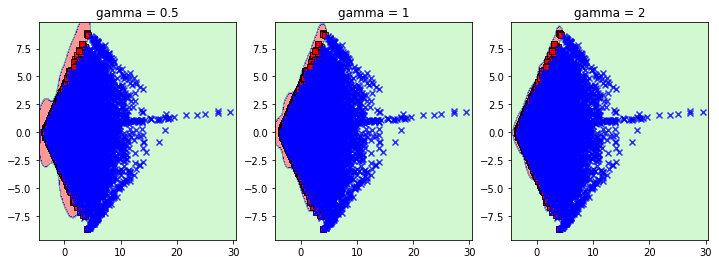

In [18]:
fignum = 1
plt.figure(figsize=(12,4))

for i in [0.5,1,2]:
    clf = svm.SVC(kernel='rbf', gamma=i)
    clf.fit(x_train_pca, y_train_final)
    plt.subplot(1,3,fignum)
    plot_decision_regions(x_train_pca, y_train_final, classifier=clf)
    plt.title('gamma = ' + str(i))
    fignum = fignum + 1